In [4]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import esm


from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.genotypevae.genotypeVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import SCVIZ_CheckNet2Net


%load_ext autoreload
%autoreload 2
%matplotlib inline

#  Example data and preprocssing

1. The exmaple dataset is the subset of dataset from Jorge et al(GSE215253). The dataset have 50 sequences of wild type GATA1 and GATA1 with muations
2. The preprocessing mainly follows the scanpy's pipeline. including:  
```
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=5, min_disp=0.5)
```

3. All highly variable genes and cell type markers are seleceted for the model training and down stream analyis

4. Differentially expressed genes are calculated using:

```
sc.tl.rank_genes_groups(adata, n_genes = 50, method = "t-test", corr_method = "benjamini-hochberg",groupby = "variant_seq",
 reference = adata.uns["refseq_protein"])
```



In [5]:
# you can provide your customized data path
adata = ad.read_h5ad("../example_data/Jorge_example.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 15616 × 2563
    obs: 'cell', 'cell_barcodes', 'Nucleotide Edits', 'variant_seq', 'n_counts_total', 'UTR_cond', 'mutation_name', 'mutation_poi', 'split1'
    var: 'id', 'feature_type', 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'ordered_all_embedding', 'ordered_all_trt', 'ordered_mutated_GATA1', 'ordered_mutated_embedding', 'refseq_protein'
    layers: 'counts'

# Create embeddings for coding variants
1. download  and load ESM_1v model by running

```
esm.pretrained.esm1v_t33_650M_UR90S()

```

2. We have already created embeddings for all sequences in the example dataset. All sequences are ordered and stored in 
```adata.uns["ordered_all_trt"]``` and their corresponding embeddings are stored in ```adata.uns["ordered_all_embedding"]```


In [7]:
# load downloaded ESM model
path_ESM = ""
torch.hub.set_dir(path_ESM)
model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1v_t33_650M_UR90S_1.pt" to checkpoints/esm1v_t33_650M_UR90S_1.pt
/nfs/turbo/umms-welchjd/wzqian/conda_env_new/PerturbNet_scvi0.7_Bart/lib/python3.7/site-packages/esm/pretrained.py:216: UserWarning: Regression weights not found, predicting contacts will not produce correct results.


In [8]:
# create embeddings using all sequences in the model
# Be careful of your batch size as this step could be memory heavy
ordered_trt = adata.obs.variant_seq.unique()[0:6]
ordered_trt_embeddings = Seq_to_Embed_ESM(ordered_trt, batch_size = 2, model = model, alphabet = alphabet ,save_path = None)

100%|██████████| 3/3 [00:36<00:00, 12.31s/it]


# Create train-test splits
Add new splits to the anndata

In [4]:
# Create train-test splits
create_train_test_splits_by_key(adata,train_ratio = 0.8, add_key = "split2", split_key = "variant_seq", 
                                control = [adata.uns["refseq_protein"]]
                                , random_seed=42)

In [4]:
adata

AnnData object with n_obs × n_vars = 15616 × 2563
    obs: 'cell', 'cell_barcodes', 'Nucleotide Edits', 'variant_seq', 'n_counts_total', 'UTR_cond', 'mutation_name', 'mutation_poi', 'split1'
    var: 'id', 'feature_type', 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'ordered_all_embedding', 'ordered_all_trt', 'ordered_mutated_GATA1', 'ordered_mutated_embedding', 'refseq_protein'
    layers: 'counts'

In [8]:
# save updated adata
adata.write_h5ad("../example_data/Jorge_example.h5ad")
#adata = ad.read_h5ad("adata_marker_hvg_example_split.h5ad")

In [9]:
adata_train = adata[adata.obs.split1 == "train",:].copy()
adata_test = adata[adata.obs.split1 == "test",:].copy()

# Train SCVI model for cell represesntation
we recommend to train scvi(version 0.7.1) for 700 epochs(at least 400 epochs for the KL to warmup)

In [10]:
# Train SCVI model, 700 epoches are recommended
# provide an unexisting directory for saving
scvi_model_save_path = "./Jorge_example/cellvae/"
scvi.data.setup_anndata(adata_train , layer = "counts")
scvi_model = scvi.model.SCVI(adata_train, n_latent = 10)
scvi_model.train(n_epochs = 700,frequency = 20)
scvi_model.save(scvi_model_save_path )

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 12435 cells, 2563 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Training for 700 epochs                                                                                   
INFO     KL warmup for 400 epochs                                       

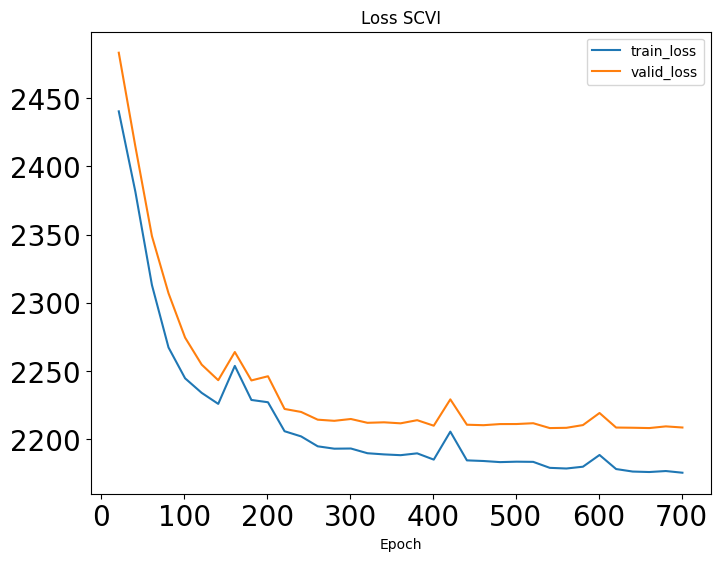

In [12]:
train_loss = np.array(scvi_model.history["elbo_train_set"])
valid_loss = np.array(scvi_model.history["elbo_test_set"])
train_time = np.arange(1,720,20)
trainvalid_loss = np.concatenate([train_loss.reshape([train_loss.shape[0], 1]), 
									  valid_loss.reshape([valid_loss.shape[0], 1])], axis = 1)
trainvalid_loss_pd = pd.DataFrame(trainvalid_loss)
trainvalid_loss_pd.columns = ['train_loss', 'valid_loss']
trainvalid_loss_pd['Epoch'] = train_time 
newfig = trainvalid_loss_pd.iloc[1:,].set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss SCVI")
plt.show()

In [11]:
# load_scvi_model
scvi_model_save_path = "./Jorge_example/cellvae/"
scvi.data.setup_anndata(adata_train, layer = "counts")
scvi_model = scvi.model.SCVI.load(scvi_model_save_path, adata_train, use_cuda = False)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 12435 cells, 2563 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                         

# Train cinn model 

In [15]:
cond_stage_data, embeddings, perturbToEmbed= prepare_embeddings_cinn(adata_train,
                                                                     perturbation_key = "variant_seq", 
                                                                     trt_key = "ordered_all_trt", 
                                                                     embed_key = "ordered_all_embedding")

**build cinn model with customized parameters**
1. conditional_dim: dimension of perturbation latent embeddings
2. embedding_dim: dimension of latent cell embeddings
3. conditioning_depth: number of the layers for conditioanl information input(perturbation latent embeddings)
4. n_flows: number of the flow blocks
5. hidden_dim: dimension of the hidden layers
6. hidden_depth: number of the hidden layers in the flow blocks

In [18]:

torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim=1280, # dimension of your perturbation embeddings
                                         embedding_dim=10,# dimension of your cell states embeddings
                                         conditioning_depth=2,
                                         n_flows=20, # number of flow blocks
                                         in_channels=10,
                                         hidden_dim=1024,
                                         hidden_depth=2,
                                         activation="none",
                                        conditioner_use_bn=True)
cond_stage_data = np.array(adata_train.obs["variant_seq"])
model_c = Net2NetFlow_scVIFixFlow(configured_flow = flow_model,
                                  cond_stage_data = cond_stage_data,
                                  perturbToEmbedLib = perturbToEmbed,
                                   embedData = embeddings,
                                  scvi_model = scvi_model)


Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size


**train and save cinn model, please provide an unexist path**  
For dataset with regular size, we recommend to train cinn for 50 epochs, in this example dataset we just train it for 25 epochs

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
path_cinn_model_save = "./Jorge_example/cinn/"
model_c.to(device = device)
model_c.train(n_epochs = 25, batch_size = 128, lr = 4.5e-6,train_ratio=0.8)

#### save the model
model_c.save(path_cinn_model_save)

[Epoch 1/25] [Batch 20/20] [loss: 4.110168/3.564545]
[Epoch 2/25] [Batch 20/20] [loss: 3.336366/3.212382]
[Epoch 3/25] [Batch 20/20] [loss: 2.967382/2.946360]
[Epoch 4/25] [Batch 20/20] [loss: 2.723532/2.730797]
[Epoch 5/25] [Batch 20/20] [loss: 2.492396/2.549953]
[Epoch 6/25] [Batch 20/20] [loss: 2.286174/2.375527]
[Epoch 7/25] [Batch 20/20] [loss: 2.115456/2.241771]
[Epoch 8/25] [Batch 20/20] [loss: 1.973478/2.170159]
[Epoch 9/25] [Batch 20/20] [loss: 1.865108/2.081968]
[Epoch 10/25] [Batch 20/20] [loss: 1.764942/2.023812]
[Epoch 11/25] [Batch 20/20] [loss: 1.670851/1.978278]
[Epoch 12/25] [Batch 20/20] [loss: 1.610404/1.917280]
[Epoch 13/25] [Batch 20/20] [loss: 1.552808/1.922965]
[Epoch 14/25] [Batch 20/20] [loss: 1.486141/1.933817]
[Epoch 15/25] [Batch 20/20] [loss: 1.464328/1.908823]
[Epoch 16/25] [Batch 20/20] [loss: 1.397603/1.788754]
[Epoch 17/25] [Batch 20/20] [loss: 1.341619/1.815226]
[Epoch 18/25] [Batch 20/20] [loss: 1.309153/1.827701]
[Epoch 19/25] [Batch 20/20] [loss: 1.

Text(0.5, 1.0, 'Minutes: 3.7')

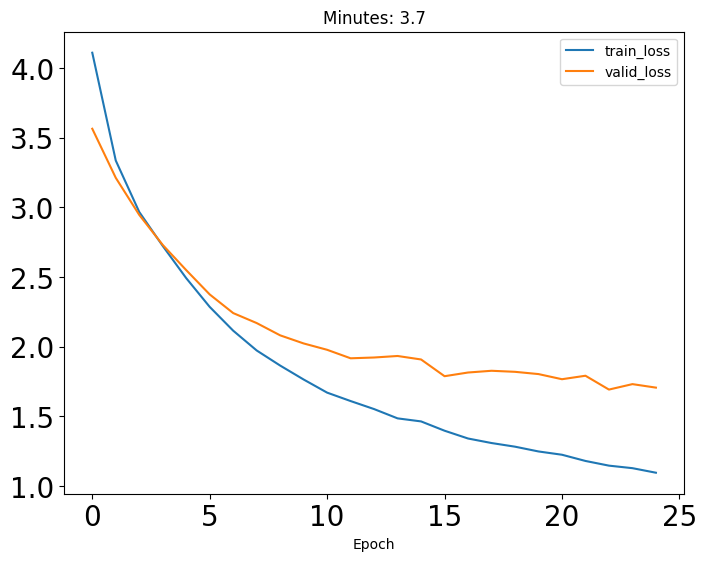

In [20]:
# loss evaluation
train_loss = np.load(path_cinn_model_save  + 'train_loss.npy')
valid_loss = np.load(path_cinn_model_save  +'test_loss.npy')
trainvalid_loss = np.concatenate([train_loss.reshape([train_loss.shape[0], 1]), 
									  valid_loss.reshape([valid_loss.shape[0], 1])], axis = 1)
trainvalid_loss_pd = pd.DataFrame(trainvalid_loss)
trainvalid_loss_pd.columns = ['train_loss', 'valid_loss']
trainvalid_loss_pd['Epoch'] = list(range(trainvalid_loss_pd.shape[0]))
train_time = np.load(path_cinn_model_save +'training_time.npy')
train_time = round(train_time/60.0, 1)
newfig = trainvalid_loss_pd.set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Minutes: " + str(train_time))

In [73]:
# if you want to load the model
model_c.load(path_cinn_model_save)
model_c.to(device = device)

Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size


# Inference

**Extract ground truth cell embeddings for the test data**  
Zsample_test is the latent cell embeddings for cells in the test set, estimated by scvi

In [21]:
Zsample_test = scvi_model.get_latent_representation(adata = adata_test, give_mean = False)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup                                     
INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category                               
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category                              
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']                           
INFO     Successfully registered anndata object containing 3181 cells, 2563 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


**Construct PerturbNet**  
scvi requires library size to make inference, so we sample the library size from observed data(Lsample_obs)

In [22]:
model_c.eval()
scvi_model_de = scvi_predictive_z(scvi_model)
perturbnet_model = SCVIZ_CheckNet2Net(model_c, device, scvi_model_de)
Lsample_obs = scvi_model.get_latent_library_size(adata = adata_train, give_mean = False)

**Prediction of Y285C,Y286C**  
predict_latent is the predicted cell representation;  
predict_data represents the predicted gene expressions;  
pert_embed is the corresponding perturbation representation.

In [23]:
unseen_pert = adata_test.obs[adata_test.obs.mutation_name == "Y285C,Y286C"]["variant_seq"].unique()[0]
pert_idx = np.where(adata_test.uns["ordered_all_trt"] == unseen_pert)[0][0]
unseen_pert_embed = adata_test.uns["ordered_all_embedding"][pert_idx]

In [47]:
n_cells = 108
Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), n_cells, replace=True)
trt_input_fixed = np.tile(unseen_pert_embed, (n_cells, 1))
pert_embed = trt_input_fixed + np.random.normal(scale = 0.001, size = trt_input_fixed.shape)
library_trt_latent = Lsample_obs[Lsample_idx]
predict_latent, predict_data = perturbnet_model.sample_data(pert_embed, library_trt_latent)

In [28]:
real_latent = Zsample_test[np.where(adata_test.obs.variant_seq  == unseen_pert)[0]]
real_latent.shape

(108, 10)

In [30]:
real_data = adata_test.layers["counts"].A[np.where(adata_test.obs.variant_seq  == unseen_pert)[0]]
real_data.shape

(108, 2563)

**Check your predicted cell representation**  
As a sanity check, the predicted latent embeddings should be mixed with the real cell embeddings.

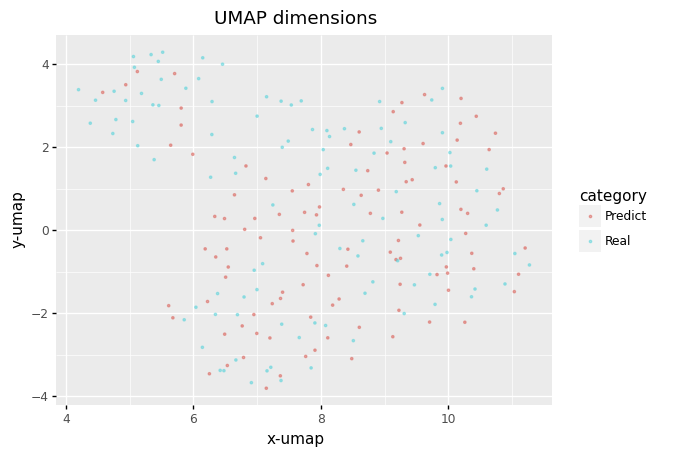

<ggplot: (1402988622945)>

In [31]:

all_latent = np.concatenate([predict_latent, real_latent], axis = 0)
cat_t = ["Real"] * real_latent.shape[0]
cat_g = ["Predict"] * predict_latent.shape[0]
cat_rf_gt = np.append(cat_g, cat_t)
trans = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit(all_latent)
X_embedded_pr = trans.transform(all_latent)
df = X_embedded_pr.copy()
df = pd.DataFrame(df)
df['x-umap'] = X_embedded_pr[:,0]
df['y-umap'] = X_embedded_pr[:,1]
df['category'] = cat_rf_gt
    
chart_pr = ggplot(df, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

**Calculate the rsquare value**

In [32]:
normModel = NormalizedRevisionRSquare(largeCountData = adata_test.layers["counts"].A)

In [33]:
r2_value, _, _ = normModel.calculate_r_square(real_data, predict_data)
r2_value

0.9182290661232322

**Visualize the mapping from the perturbation representation to the cellular representation**
1. We need to generate background embeddings for perturbations and cells, excluding the specific perturbation we want to highlight.
2. Use ```contourplot_space_mapping``` to display the mapping relationships. Ensure you specify enough colors for the highlighted perturbations

In [57]:
background_pert = []
background_cell = []
n_cells_bk = 20
highlights = [unseen_pert]
for i in tqdm(range(len(adata.uns["ordered_all_trt"]))):
    pert = adata.uns["ordered_all_trt"][i]
    if pert in highlights:
        continue
    pert_embed_tmp = adata.uns["ordered_all_embedding"][i]
    Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), n_cells, replace=True)
    trt_input_fixed_bk = np.tile(pert_embed_tmp, (n_cells_bk, 1))
    pert_embed_bk = trt_input_fixed_bk + np.random.normal(scale = 0.001, size = trt_input_fixed_bk.shape)
    library_trt_latent = Lsample_obs[Lsample_idx]
    predict_latent_bk, predict_data_bk = perturbnet_model.sample_data(pert_embed_bk, library_trt_latent)
    
    background_pert.append(pert_embed_bk )
    background_cell.append(predict_latent_bk)
    
background_pert = np.concatenate(background_pert)
background_cell = np.concatenate(background_cell)
    


100%|██████████| 257/257 [00:06<00:00, 41.43it/s]


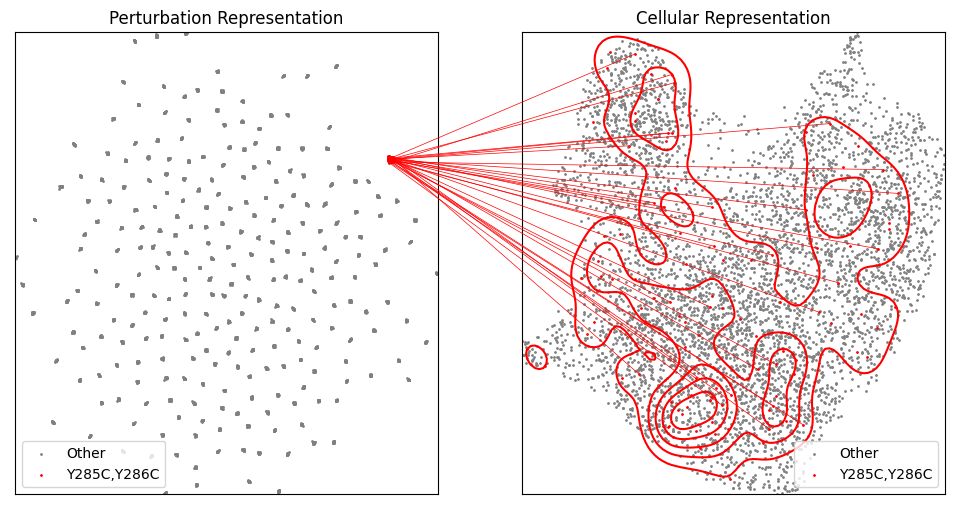

In [58]:
%matplotlib inline
contourplot_space_mapping(predict_latent, pert_embed, background_pert, background_cell, highlight_labels = ["Y285C,Y286C"], colors = ["red"])